# 1. Import Packages

In [1]:
import numpy as np
from numpy.random import seed
seed(7)
import math
import h5py
from numpy import array
from keras import initializers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import LSTM, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# 2. Data Normalization

In [2]:
def scale_data(X):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    #scaler.fit(X)
    #ret = scaler.transform(X)
    ret = np.empty(shape = X.shape)
    for idx,r in enumerate(X):
        norm = np.linalg.norm(r)
        scaled = r/norm
        ret[idx] = scaled
    return ret

# 3. Label Smoothing -- only available with Keras 2.3.1+

In [ ]:
def cce_function(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

# 4. Read Data in Batches

In [3]:
def batch_generator(X, Y, batch_size, shuffle=False):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        # it might be a good idea to shuffle your data before each epoch
        if shuffle:
            np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], Y[batch]
                batch=[]

# 5. Pre-processing Train/Val/Test Data

In [4]:
train_fname = 'vector-data/train.csv'
raw_train = open(train_fname, 'rt')
train_data = np.loadtxt(raw_train, delimiter=",")
train_X = train_data[:,1:8193]
train_Y = train_data[:,8193]
train_X = scale_data(train_X)
train_Y = to_categorical(train_Y, num_classes=5)

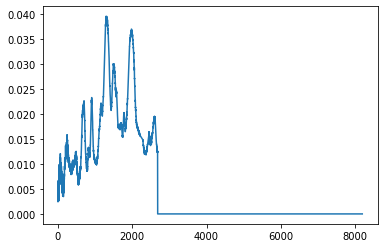

In [5]:
plt.plot(train_X[1])

In [6]:
val_fname = 'vector-data/val.csv'
raw_val = open(val_fname, 'rt')
val_data = np.loadtxt(raw_val, delimiter=",")
val_X = val_data[:,1:8193]
val_Y = val_data[:,8193]
val_X = scale_data(val_X)
val_Y = to_categorical(val_Y, num_classes=5)

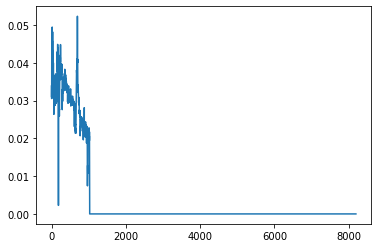

In [7]:
plt.plot(val_X[1287])

In [8]:
test_fname = 'vector-data/test.csv'
raw_test = open(test_fname, 'rt')
test_data = np.loadtxt(raw_test, delimiter=",")
test_X = test_data[:,1:8193]
test_Y = test_data[:,8193]
test_X = scale_data(test_X)
test_Y = to_categorical(test_Y, num_classes=5)

# 6. Model definition -- VGG-16 like

In [9]:
# define model
k = 15
train_X = train_X.reshape((len(train_X), 8192, 1))
val_X = val_X.reshape((len(val_X), 8192, 1))
test_X = test_X.reshape((len(test_X), 8192, 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu', input_shape=(8192,1)))
model.add(Conv1D(filters=64, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, padding='same'))

model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=k, kernel_initializer='he_normal', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 7. Optimizer and Compiling Model

In [10]:
opt = Adam(lr=1e-5, clipvalue=5)
#model.compile(optimizer=opt, loss=cce_function, metrics=['accuracy'])
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8192, 64)          1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8192, 64)          61504     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2048, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 128)         123008    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 128)         245888    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 256)          491776    
________

# 8. Iteraters, Batch Size, and Callbacks

In [11]:
batch_size = 16
train_it = batch_generator(train_X, train_Y, batch_size, shuffle=True)
val_it = batch_generator(val_X, val_Y, batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=math.sqrt(0.1),
                              patience=5, min_lr=1e-8, verbose=1)

In [12]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'spectra_model.{epoch:03d}.h5'
model_name = 'spectra_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# 9. Train

In [13]:
model.fit_generator(train_it,
                    steps_per_epoch=len(train_X)//batch_size,
                    validation_data=val_it,
                    validation_steps=len(val_X)//batch_size,
                    epochs=50,
                    callbacks=[reduce_lr, checkpoint],
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





281/281 [==============================] - 31s 111ms/step - loss: 1.6060 - acc: 0.2229 - val_loss: 1.5837 - val_acc: 0.3344

Epoch 00001: val_acc improved from -inf to 0.33437, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 2/50
281/281 [==============================] - 25s 88ms/step - loss: 1.5873 - acc: 0.2662 - val_loss: 1.5613 - val_acc: 0.3367

Epoch 00002: val_acc improved from 0.33437 to 0.33672, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 3/50
281/281 [==============================] - 25s 89ms/step - loss: 1.5737 - acc: 0.2820 - val_loss: 1.5258 - val_acc: 0.3469

Epoch 00003: val_acc improved from 0.33672 to 0.34687, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 4/50
281/281 [==============================] - 25s 89ms/step - loss: 1.5436 - acc: 0.3087 - val_loss:

281/281 [==============================] - 25s 89ms/step - loss: 0.5255 - acc: 0.8072 - val_loss: 0.7988 - val_acc: 0.7016

Epoch 00026: val_acc did not improve from 0.75781
Epoch 27/50
281/281 [==============================] - 25s 89ms/step - loss: 0.5016 - acc: 0.8236 - val_loss: 0.6939 - val_acc: 0.7391

Epoch 00027: val_acc did not improve from 0.75781
Epoch 28/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4610 - acc: 0.8350 - val_loss: 0.6627 - val_acc: 0.7680

Epoch 00028: val_acc improved from 0.75781 to 0.76797, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 29/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4435 - acc: 0.8432 - val_loss: 0.6525 - val_acc: 0.7789

Epoch 00029: val_acc improved from 0.76797 to 0.77891, saving model to /home1/00946/zzhang/spectra/saved_models/spectra_model.h5
Epoch 30/50
281/281 [==============================] - 25s 89ms/step - loss: 0.4120 - acc: 0.8583 - val_loss: 

# 10. Validate

In [14]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Measured Performance',
           xlabel='Predicted Performance')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion Matrix
[[260  12  15   8   5]
 [ 18 186  34   3   9]
 [ 25  32 209   7   4]
 [  5   9  10 165  15]
 [  5  13   4  15 220]]
Confusion matrix, without normalization


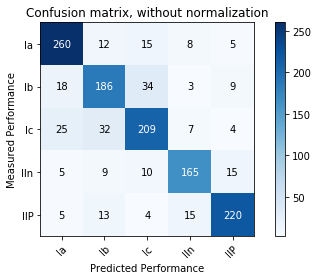

In [15]:
val_it = batch_generator(val_X, val_Y, 1)
Y_pred = model.predict_generator(val_it, 1288)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data[:,8193], y_pred))
plot_confusion_matrix(array(np.argmax(val_Y, axis=1)), array(y_pred), classes=array(['Ia', 'Ib', 'Ic', 'IIn', 'IIP']), title='Confusion matrix, without normalization')

# 11. Test

In [16]:
test_it = batch_generator(test_X, test_Y, 1)
Y_pred = model.predict_generator(test_it, len(test_X))
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data[:,8193], y_pred))

Confusion Matrix
[[128  10   7   3   2]
 [  4  94  21   1   5]
 [  7  21 106   4   1]
 [  1   3   4  91   4]
 [  3  12   3   4 107]]


# 12. Visualizing Test Result in Confusion Matrix

Confusion matrix, without normalization


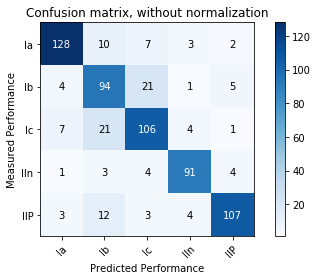

In [17]:
plot_confusion_matrix(array(np.argmax(test_Y, axis=1)), array(y_pred), classes=array(['Ia', 'Ib', 'Ic', 'IIn', 'IIP']), title='Confusion matrix, without normalization')

# 13. Load Model

In [18]:
l_model = load_model("saved_models/spectra_model.h5")

# 14. Single Prediction

In [19]:
idx = np.random.randint(0, len(test_X))
pred = l_model.predict(test_X[idx].reshape(1,8192,1))
print(f"predict: {np.argmax(pred)}, label: {np.argmax(test_Y[idx])}")

predict: 2, label: 2


# 15. Batch Prediction -- Test

In [20]:
test_it = batch_generator(test_X, test_Y, 1)
Y_pred = l_model.predict_generator(test_it, len(test_X))
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data[:,8193], y_pred))

Confusion Matrix
[[123   9  14   3   1]
 [  2  88  24   5   6]
 [  5  20 108   4   2]
 [  1   3   4  90   5]
 [  4   5   5  10 105]]


Confusion matrix, without normalization


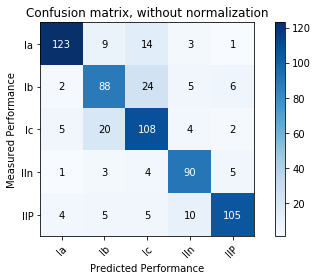

In [21]:
plot_confusion_matrix(array(np.argmax(test_Y, axis=1)), array(y_pred), classes=array(['Ia', 'Ib', 'Ic', 'IIn', 'IIP']), title='Confusion matrix, without normalization')